# Janus gym environment

In [25]:
import gym
from gym import spaces
import random
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN, DDPG
from math import sqrt
import numpy as np
import pandas as pd
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.datasets import make_regression

import math
import pickle

class Janus(gym.Env):
    metadata = {'render.modes': ['human']}
    template_filename = 'data/dataset-S_public/public/dataset_S-{}.csv'

    def __init__(self):
        super(Janus, self).__init__()
        #actions: move on the grid, by continuous value in -1,1
        #0,0 no move
        #based on 94 controlable parameters
        #"We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) ", we will multiply effect by 2
#         self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(94, ))
        #we focus on the 1 most influencal action
        nbr_actions = 4
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(nbr_actions, ))
    

        # all the observation_space
        self.observation_space = spaces.Box(low=-1.0, high=1.0, shape=(228, ))

        file1 = pd.read_csv(self.template_filename.format('file1'), index_col=0)
        file2 = pd.read_csv(self.template_filename.format('file2'), index_col=0)
        file3 = pd.read_csv(self.template_filename.format('file3'), index_col=0)
        vav = pd.read_csv(self.template_filename.format('VAV'), index_col=0)
        self.ti = pd.read_csv(self.template_filename.format('TI'), index_col=0)
        self.ts = pd.read_csv(self.template_filename.format('TS'), index_col=0)
        x_df = file1.copy()
        x_df = x_df.loc[:, (x_df != 0).any(axis=0)]  ## remove static columns
        x_df = x_df.fillna(x_df.mean())  ## replace nan with mean

        self.y_df = file2.copy()
        self.y_df.dropna(how='all', axis=1,
                    inplace=True)  ## drop full tempty columns
        self.y_df = self.y_df.fillna(self.y_df.mean())

        self.vav_df = vav.copy()
        # Dropping few columns
        for dataset in [self.y_df, self.vav_df, self.ti, self.ts]:
            dataset.drop(['target_1', 'target_2', 'target_3', 'target_4'],
                  axis=1,
                  inplace=True)  #to simplify with a 2-dimension target space

        print('features shape: {}, \ntargets shape: {}'.format(
            x_df.shape, self.y_df.shape))

        x_train, x_test, y_train, y_test = train_test_split(x_df,
                                                            self.y_df,
                                                            test_size=0.1,
                                                            random_state=14)
        print('\nLength of train is {}, test is {}'.format(
            len(x_train), len(x_test)))
        ## Random forest
        filename = 'data/models/janus_RF.pkl'  # janus_LinearReg, janus_RF

        # pickle.dump(ml_model, open(filename, 'wb'))

        # # load the model from disk
        self.ml_model = pickle.load(open(filename, 'rb'))
        print(f'R squared: {self.ml_model.score(x_test, y_test.values):0.04f}')

        self.full_x = file3.copy()[x_df.columns]
        self.full_x = self.full_x.fillna(x_df.mean())
        
        self.partial_x = x_train.copy()

        inferred_y = pd.DataFrame(self.ml_model.predict(self.full_x),
                                  columns=self.y_df.columns)

        # list of [min, max, step, range] for each var
        scale = 100
        decimals = 3
        
        self.list_important_actions = np.argsort(self.ml_model.feature_importances_[:94])[::-1][:nbr_actions]

        ## get limits for Rewards
        self.output_steps = [round((self.y_df[i].max() - self.y_df[i].min())/scale, decimals) \
                        for i in self.y_df.columns]
        print('Output steps: ', self.output_steps)

    def reset(self):
#         self.current_position = self.revert_to_obs_space(
#             self.full_x.sample().values.reshape(-1), self.full_x)
        random.seed(13)
        idx = random.randint(0,len(janus_env.partial_x)-1)
        idx = 47
        self.current_position = self.revert_to_obs_space(
            self.full_x.iloc[idx].values.reshape(-1), self.full_x)
        
        # to fix The observation returned by the `reset()` method does not match the given observation space
        # maybe won't happen on linux
        # on windows looks like float64 is the defautl for pandas -> numpy and gym expects float32 (contains tries to cast to dtype(float32))
        self.current_position = self.current_position.astype('float32')
        
        self.last_action = self.current_position[self.list_important_actions]
        self.last_effect = False
        self.global_reward = 0
        self.episode_length = 0
        #print(f'reset at position {self.current_position[:10]}...')
        return self.current_position

    def step(self, action):
#         self.current_position[0:len(action)] = action
        for index, act in enumerate(self.list_important_actions):
            self.current_position[act]=action[index]
        self.last_action = action
        self.episode_length += 1
        done = False
        
        reward = self.reward(
            self.convert_to_real_obs(self.current_position,
                                     self.full_x).values.reshape(1,-1))
        if (reward >= -0.1*self.y_df.shape[1]):
            done = True
        
#         print(f'target reached {done} reward {reward:0.03f} n° step {self.episode_length} action {self.last_action} done threeshold {-0.1*self.y_df.shape[1]:0.03f}')
        
        if done:
            reward += 100
        
        if self.episode_length>100:
            print('episode too long -> reset')
            done = True
            
#         if (max(abs(action))==1):
#             # if on border, we kill episode
#             print('border reached -> done -> reset')
#             reward -= 50
#             done = True
            

        self.global_reward += reward
#         print(f'  reward {reward:0.03f} global reward {self.global_reward:0.03f} done {done} action {action} step {self.episode_length}')
        return self.current_position, reward, done, {}

    def render(self):
        print(
            f'position {self.current_position[:10]}, action {self.last_action[:5]}, effect {self.last_effect}, done {done}, global_reward {self.global_reward:0.03f}'
        )

    def convert_to_real_obs(self, observation, observation_dataset):
        '''
        to convert an observation from observation space ([-1, 1],325) to  real world
        -1 matches with min() of each column
        1 matches with max() of each column
        
        observation: instance of observation_space
        observation_dataset: the full real dataset (obfuscated in that case)
        '''
        return (observation + np.ones(self.observation_space.shape)) / 2 * (
            observation_dataset.max() -
            observation_dataset.min()) + observation_dataset.min()

    def revert_to_obs_space(self, real_observation, observation_dataset):
        '''
        to revert an observation sample (from real world) to observation space
        min() of each column will match with -1
        max() of each column will match with +1
        
        real_observation: instance of real_world
        observation_dataset: the full real dataset (obfuscated in that case)
        '''
        return np.nan_to_num(
            2 * (real_observation - observation_dataset.min()) /
            (observation_dataset.max() - observation_dataset.min()) -
            np.ones(self.observation_space.shape)).reshape(-1)

    def reward(self, observation):
        ''' Discrete reward 
        observation if from real world not observation space
        '''

        new_y = self.ml_model.predict(observation).reshape(-1)
        return self.continuous_reward_clown_hat(new_y)

    def discrete_reward(self, new_y):
        ''' Discrete reward '''

        new_val = [
            sqrt((self.vav_df.iloc[:, i].values[0] - new_y[i])**2)
            for i in range(len(new_y))
        ]
        k = 10
        k1 = 1
        if new_val[0] < k * self.output_steps[0] and new_val[
                1] < k * self.output_steps[1]:
            reward = 1  #dans les 10% d'amplitude max autour de la vav
            if new_val[0] < k1 * self.output_steps[0] and new_val[
                    1] < k1 * self.output_steps[1]:
                reward = 10  #dans les 1% d'amplitude max autour de la vav
                on_target = True
#                 print('On Target : ', new_y)
        else:
            reward = -1
        return reward
    
    
    
    def continuous_reward_clown_hat(self, new_y):
        ''' Continuous reward '''
        final_reward = 0 

        for i in range(len(new_y)):
            reward = -9
            if ( self.ti.iloc[:,i].values[0] <=  new_y[i] <= self.ts.iloc[:,i].values[0]):
                if ( new_y[i] >= self.vav_df.iloc[:,i].values[0] ):
                    reward = 1-(new_y[i]-self.vav_df.iloc[:,i].values[0])/(self.ts.iloc[:,i].values[0]-self.vav_df.iloc[:,i].values[0])
                else:
                    reward = 1-(new_y[i]-self.ti.iloc[:,i].values[0])/(self.vav_df.iloc[:,i].values[0]-self.ti.iloc[:,i].values[0])
            reward += -1
            final_reward+=reward
    #         print(f'reward {reward} final_reward {final_reward} i {i}')

        if (final_reward>0.7*len(new_y)):
            on_target = True
    #         print('On Target : ', new_y)

        return final_reward




In [26]:
janus_env = Janus()
from stable_baselines3.common.env_checker import check_env

check_env(janus_env)

features shape: (782, 228), 
targets shape: (782, 2)

Length of train is 703, test is 79
R squared: 0.6615
Output steps:  [0.064, 0.057]


# SAC training

In [127]:
from stable_baselines3 import SAC

janus_env = Janus()
check_env(janus_env)

model_janus_sac = SAC("MlpPolicy", janus_env, verbose=2,tensorboard_log="./tensorboard/")
model_janus_sac.learn(total_timesteps=100000, log_interval=4, tb_log_name="janus partial sac")

janus_env.reset()
for i in range(100):
    action, _ = model_janus_sac.predict(janus_env.current_position)
    print(f'action {action}')
    obs, rewards, done, info = janus_env.step(action)
    janus_env.render()
    if done: break
janus_env.close()

features shape: (782, 228), 
targets shape: (782, 2)

Length of train is 703, test is 79
R squared: 0.6550
Output steps:  [0.064, 0.057]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard/janus partial sac_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 27       |
|    time_elapsed    | 14       |
|    total timesteps | 404      |
| train/             |          |
|    actor_loss      | 0.392    |
|    critic_loss     | 0.0128   |
|    ent_coef        | 0.913    |
|    ent_coef_loss   | -0.153   |
|    learning_rate   | 0.0003   |
|    n_updates       | 303      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/   

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 60       |
|    fps             | 24       |
|    time_elapsed    | 244      |
|    total timesteps | 6060     |
| train/             |          |
|    actor_loss      | 16.6     |
|    critic_loss     | 0.957    |
|    ent_coef        | 0.168    |
|    ent_coef_loss   | -3.01    |
|    learning_rate   | 0.0003   |
|    n_updates       | 5959     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 64       |
|    fps             | 24       |
|    time_elapsed    | 260      |
|    total timesteps | 6464     |
| train/             |          |
|    actor_loss      | 17.7     |
|    critic_loss     | 3.35     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 120      |
|    fps             | 23       |
|    time_elapsed    | 517      |
|    total timesteps | 12120    |
| train/             |          |
|    actor_loss      | 30.4     |
|    critic_loss     | 17.2     |
|    ent_coef        | 0.0301   |
|    ent_coef_loss   | -2.55    |
|    learning_rate   | 0.0003   |
|    n_updates       | 12019    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 124      |
|    fps             | 23       |
|    time_elapsed    | 536      |
|    total timesteps | 12524    |
| train/             |          |
|    actor_loss      | 31       |
|    critic_loss     | 3.8      |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 180      |
|    fps             | 22       |
|    time_elapsed    | 799      |
|    total timesteps | 18180    |
| train/             |          |
|    actor_loss      | 39.1     |
|    critic_loss     | 46.2     |
|    ent_coef        | 0.00898  |
|    ent_coef_loss   | -0.818   |
|    learning_rate   | 0.0003   |
|    n_updates       | 18079    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 184      |
|    fps             | 22       |
|    time_elapsed    | 817      |
|    total timesteps | 18584    |
| train/             |          |
|    actor_loss      | 39.4     |
|    critic_loss     | 17.5     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 240      |
|    fps             | 22       |
|    time_elapsed    | 1059     |
|    total timesteps | 24240    |
| train/             |          |
|    actor_loss      | 42.9     |
|    critic_loss     | 29       |
|    ent_coef        | 0.00689  |
|    ent_coef_loss   | 1.22     |
|    learning_rate   | 0.0003   |
|    n_updates       | 24139    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 244      |
|    fps             | 22       |
|    time_elapsed    | 1076     |
|    total timesteps | 24644    |
| train/             |          |
|    actor_loss      | 43.8     |
|    critic_loss     | 28.9     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 300      |
|    fps             | 23       |
|    time_elapsed    | 1304     |
|    total timesteps | 30300    |
| train/             |          |
|    actor_loss      | 46.5     |
|    critic_loss     | 24.5     |
|    ent_coef        | 0.00742  |
|    ent_coef_loss   | -0.483   |
|    learning_rate   | 0.0003   |
|    n_updates       | 30199    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 304      |
|    fps             | 23       |
|    time_elapsed    | 1320     |
|    total timesteps | 30704    |
| train/             |          |
|    actor_loss      | 46.5     |
|    critic_loss     | 57       |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 360      |
|    fps             | 23       |
|    time_elapsed    | 1547     |
|    total timesteps | 36360    |
| train/             |          |
|    actor_loss      | 48.3     |
|    critic_loss     | 17.7     |
|    ent_coef        | 0.00579  |
|    ent_coef_loss   | -2       |
|    learning_rate   | 0.0003   |
|    n_updates       | 36259    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 364      |
|    fps             | 23       |
|    time_elapsed    | 1563     |
|    total timesteps | 36764    |
| train/             |          |
|    actor_loss      | 48.4     |
|    critic_loss     | 26.6     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 420      |
|    fps             | 23       |
|    time_elapsed    | 1795     |
|    total timesteps | 42420    |
| train/             |          |
|    actor_loss      | 49.1     |
|    critic_loss     | 36.3     |
|    ent_coef        | 0.0104   |
|    ent_coef_loss   | -0.571   |
|    learning_rate   | 0.0003   |
|    n_updates       | 42319    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 424      |
|    fps             | 23       |
|    time_elapsed    | 1811     |
|    total timesteps | 42824    |
| train/             |          |
|    actor_loss      | 49.4     |
|    critic_loss     | 0.308    |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 480      |
|    fps             | 23       |
|    time_elapsed    | 2044     |
|    total timesteps | 48480    |
| train/             |          |
|    actor_loss      | 48.9     |
|    critic_loss     | 19.5     |
|    ent_coef        | 0.00886  |
|    ent_coef_loss   | 0.605    |
|    learning_rate   | 0.0003   |
|    n_updates       | 48379    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 484      |
|    fps             | 23       |
|    time_elapsed    | 2061     |
|    total timesteps | 48884    |
| train/             |          |
|    actor_loss      | 49.4     |
|    critic_loss     | 27.9     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 540      |
|    fps             | 23       |
|    time_elapsed    | 2301     |
|    total timesteps | 54540    |
| train/             |          |
|    actor_loss      | 49.9     |
|    critic_loss     | 0.438    |
|    ent_coef        | 0.0116   |
|    ent_coef_loss   | 0.546    |
|    learning_rate   | 0.0003   |
|    n_updates       | 54439    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 544      |
|    fps             | 23       |
|    time_elapsed    | 2319     |
|    total timesteps | 54944    |
| train/             |          |
|    actor_loss      | 50.1     |
|    critic_loss     | 28.3     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 600      |
|    fps             | 23       |
|    time_elapsed    | 2563     |
|    total timesteps | 60600    |
| train/             |          |
|    actor_loss      | 49.9     |
|    critic_loss     | 37.9     |
|    ent_coef        | 0.0121   |
|    ent_coef_loss   | 1.63     |
|    learning_rate   | 0.0003   |
|    n_updates       | 60499    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 604      |
|    fps             | 23       |
|    time_elapsed    | 2581     |
|    total timesteps | 61004    |
| train/             |          |
|    actor_loss      | 49.9     |
|    critic_loss     | 38       |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 660      |
|    fps             | 23       |
|    time_elapsed    | 2831     |
|    total timesteps | 66660    |
| train/             |          |
|    actor_loss      | 50.4     |
|    critic_loss     | 28.8     |
|    ent_coef        | 0.00798  |
|    ent_coef_loss   | 0.869    |
|    learning_rate   | 0.0003   |
|    n_updates       | 66559    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 664      |
|    fps             | 23       |
|    time_elapsed    | 2848     |
|    total timesteps | 67064    |
| train/             |          |
|    actor_loss      | 50.5     |
|    critic_loss     | 9.69     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 720      |
|    fps             | 23       |
|    time_elapsed    | 3104     |
|    total timesteps | 72720    |
| train/             |          |
|    actor_loss      | 50.7     |
|    critic_loss     | 9.71     |
|    ent_coef        | 0.00558  |
|    ent_coef_loss   | 1.4      |
|    learning_rate   | 0.0003   |
|    n_updates       | 72619    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 724      |
|    fps             | 23       |
|    time_elapsed    | 3123     |
|    total timesteps | 73124    |
| train/             |          |
|    actor_loss      | 50       |
|    critic_loss     | 19.5     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 780      |
|    fps             | 23       |
|    time_elapsed    | 3378     |
|    total timesteps | 78780    |
| train/             |          |
|    actor_loss      | 50.3     |
|    critic_loss     | 29       |
|    ent_coef        | 0.012    |
|    ent_coef_loss   | 1.35     |
|    learning_rate   | 0.0003   |
|    n_updates       | 78679    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 784      |
|    fps             | 23       |
|    time_elapsed    | 3397     |
|    total timesteps | 79184    |
| train/             |          |
|    actor_loss      | 50.4     |
|    critic_loss     | 38.6     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 840      |
|    fps             | 23       |
|    time_elapsed    | 3652     |
|    total timesteps | 84840    |
| train/             |          |
|    actor_loss      | 50.2     |
|    critic_loss     | 38.5     |
|    ent_coef        | 0.00897  |
|    ent_coef_loss   | 1.4      |
|    learning_rate   | 0.0003   |
|    n_updates       | 84739    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 844      |
|    fps             | 23       |
|    time_elapsed    | 3670     |
|    total timesteps | 85244    |
| train/             |          |
|    actor_loss      | 50.6     |
|    critic_loss     | 19.4     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 900      |
|    fps             | 23       |
|    time_elapsed    | 3923     |
|    total timesteps | 90900    |
| train/             |          |
|    actor_loss      | 50       |
|    critic_loss     | 19.9     |
|    ent_coef        | 0.00513  |
|    ent_coef_loss   | -1.88    |
|    learning_rate   | 0.0003   |
|    n_updates       | 90799    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 904      |
|    fps             | 23       |
|    time_elapsed    | 3941     |
|    total timesteps | 91304    |
| train/             |          |
|    actor_loss      | 50.1     |
|    critic_loss     | 9.91     |
|    ent_coef 

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 960      |
|    fps             | 23       |
|    time_elapsed    | 4196     |
|    total timesteps | 96960    |
| train/             |          |
|    actor_loss      | 51       |
|    critic_loss     | 29.2     |
|    ent_coef        | 0.00438  |
|    ent_coef_loss   | -0.846   |
|    learning_rate   | 0.0003   |
|    n_updates       | 96859    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -101     |
| time/              |          |
|    episodes        | 964      |
|    fps             | 23       |
|    time_elapsed    | 4214     |
|    total timesteps | 97364    |
| train/             |          |
|    actor_loss      | 50       |
|    critic_loss     | 10.2     |
|    ent_coef 

position [ 0.874066   -0.76       -0.67567568 -0.52941176  0.93877551 -0.98089959
 -0.63076923 -0.63076923 -0.2         0.        ], action [0.874066], effect False, done False, global_reward -24
action [0.96536136]
position [ 0.96536136 -0.76       -0.67567568 -0.52941176  0.93877551 -0.98089959
 -0.63076923 -0.63076923 -0.2         0.        ], action [0.96536136], effect False, done False, global_reward -25
action [0.9551518]
position [ 0.9551518  -0.76       -0.67567568 -0.52941176  0.93877551 -0.98089959
 -0.63076923 -0.63076923 -0.2         0.        ], action [0.9551518], effect False, done False, global_reward -26
action [0.98472524]
position [ 0.98472524 -0.76       -0.67567568 -0.52941176  0.93877551 -0.98089959
 -0.63076923 -0.63076923 -0.2         0.        ], action [0.98472524], effect False, done False, global_reward -27
action [0.29568815]
position [ 0.29568815 -0.76       -0.67567568 -0.52941176  0.93877551 -0.98089959
 -0.63076923 -0.63076923 -0.2         0.        ],

position [ 0.9500246  -0.76       -0.67567568 -0.52941176  0.93877551 -0.98089959
 -0.63076923 -0.63076923 -0.2         0.        ], action [0.9500246], effect False, done False, global_reward -62
action [0.8876209]
position [ 0.88762093 -0.76       -0.67567568 -0.52941176  0.93877551 -0.98089959
 -0.63076923 -0.63076923 -0.2         0.        ], action [0.8876209], effect False, done False, global_reward -63
action [0.9898963]
position [ 0.9898963  -0.76       -0.67567568 -0.52941176  0.93877551 -0.98089959
 -0.63076923 -0.63076923 -0.2         0.        ], action [0.9898963], effect False, done False, global_reward -64
action [0.9649997]
position [ 0.96499968 -0.76       -0.67567568 -0.52941176  0.93877551 -0.98089959
 -0.63076923 -0.63076923 -0.2         0.        ], action [0.9649997], effect False, done False, global_reward -65
action [0.99591553]
position [ 0.99591553 -0.76       -0.67567568 -0.52941176  0.93877551 -0.98089959
 -0.63076923 -0.63076923 -0.2         0.        ], ac

# TD3 training

In [27]:
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

model_name = "janus partial td3 - reward clown hat noborder"

janus_env = Janus()
check_env(janus_env)

n_actions = janus_env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))

model_janus_td3 = TD3("MlpPolicy", janus_env, action_noise=action_noise, verbose=2,tensorboard_log="./tensorboard/")
model_janus_td3.learn(total_timesteps=1000, log_interval=4, tb_log_name=model_name)
model_janus_td3.save("./data/"+model_name)

features shape: (782, 228), 
targets shape: (782, 2)

Length of train is 703, test is 79
R squared: 0.6615
Output steps:  [0.064, 0.057]
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard/janus partial td3 - reward clown hat noborder_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8        |
|    ep_rew_mean     | 93       |
| time/              |          |
|    episodes        | 4        |
|    fps             | 21       |
|    time_elapsed    | 1        |
|    total timesteps | 32       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 91       |
| time/              |          |
|    episodes        | 8        |
|    fps             | 23       |
|    time_elapsed    | 3        |
|    total timesteps | 80       |
---------------------------------
episode too long

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.57     |
|    ep_rew_mean     | 96       |
| time/              |          |
|    episodes        | 72       |
|    fps             | 15       |
|    time_elapsed    | 16       |
|    total timesteps | 257      |
| train/             |          |
|    actor_loss      | -90.3    |
|    critic_loss     | 626      |
|    learning_rate   | 0.001    |
|    n_updates       | 160      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.43     |
|    ep_rew_mean     | 96.2     |
| time/              |          |
|    episodes        | 76       |
|    fps             | 15       |
|    time_elapsed    | 16       |
|    total timesteps | 261      |
| train/             |          |
|    actor_loss      | -70.3    |
|    critic_loss     | 282      |
|    learning_rate   | 0.001    |
|    n_updates       | 164      |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 140      |
|    fps             | 13       |
|    time_elapsed    | 23       |
|    total timesteps | 325      |
| train/             |          |
|    actor_loss      | -88.4    |
|    critic_loss     | 429      |
|    learning_rate   | 0.001    |
|    n_updates       | 228      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 144      |
|    fps             | 13       |
|    time_elapsed    | 23       |
|    total timesteps | 329      |
| train/             |          |
|    actor_loss      | -86.2    |
|    critic_loss     | 378      |
|    learning_rate   | 0.001    |
|    n_updates       | 232      |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 208      |
|    fps             | 13       |
|    time_elapsed    | 30       |
|    total timesteps | 393      |
| train/             |          |
|    actor_loss      | -92.1    |
|    critic_loss     | 105      |
|    learning_rate   | 0.001    |
|    n_updates       | 296      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 212      |
|    fps             | 13       |
|    time_elapsed    | 30       |
|    total timesteps | 397      |
| train/             |          |
|    actor_loss      | -91.1    |
|    critic_loss     | 191      |
|    learning_rate   | 0.001    |
|    n_updates       | 300      |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 276      |
|    fps             | 12       |
|    time_elapsed    | 36       |
|    total timesteps | 461      |
| train/             |          |
|    actor_loss      | -96.6    |
|    critic_loss     | 343      |
|    learning_rate   | 0.001    |
|    n_updates       | 364      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 280      |
|    fps             | 12       |
|    time_elapsed    | 37       |
|    total timesteps | 465      |
| train/             |          |
|    actor_loss      | -93.8    |
|    critic_loss     | 178      |
|    learning_rate   | 0.001    |
|    n_updates       | 368      |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 344      |
|    fps             | 12       |
|    time_elapsed    | 43       |
|    total timesteps | 529      |
| train/             |          |
|    actor_loss      | -98.5    |
|    critic_loss     | 132      |
|    learning_rate   | 0.001    |
|    n_updates       | 432      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 348      |
|    fps             | 12       |
|    time_elapsed    | 43       |
|    total timesteps | 533      |
| train/             |          |
|    actor_loss      | -94.8    |
|    critic_loss     | 167      |
|    learning_rate   | 0.001    |
|    n_updates       | 436      |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 412      |
|    fps             | 12       |
|    time_elapsed    | 49       |
|    total timesteps | 597      |
| train/             |          |
|    actor_loss      | -96.2    |
|    critic_loss     | 64.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 500      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 416      |
|    fps             | 12       |
|    time_elapsed    | 50       |
|    total timesteps | 601      |
| train/             |          |
|    actor_loss      | -99.7    |
|    critic_loss     | 42.2     |
|    learning_rate   | 0.001    |
|    n_updates       | 504      |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 480      |
|    fps             | 11       |
|    time_elapsed    | 56       |
|    total timesteps | 665      |
| train/             |          |
|    actor_loss      | -101     |
|    critic_loss     | 141      |
|    learning_rate   | 0.001    |
|    n_updates       | 568      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 484      |
|    fps             | 11       |
|    time_elapsed    | 56       |
|    total timesteps | 669      |
| train/             |          |
|    actor_loss      | -99.5    |
|    critic_loss     | 56.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 572      |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 548      |
|    fps             | 11       |
|    time_elapsed    | 62       |
|    total timesteps | 733      |
| train/             |          |
|    actor_loss      | -97.5    |
|    critic_loss     | 93.6     |
|    learning_rate   | 0.001    |
|    n_updates       | 636      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 552      |
|    fps             | 11       |
|    time_elapsed    | 62       |
|    total timesteps | 737      |
| train/             |          |
|    actor_loss      | -99.8    |
|    critic_loss     | 17.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 640      |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 616      |
|    fps             | 11       |
|    time_elapsed    | 69       |
|    total timesteps | 801      |
| train/             |          |
|    actor_loss      | -97.6    |
|    critic_loss     | 23.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 704      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 620      |
|    fps             | 11       |
|    time_elapsed    | 69       |
|    total timesteps | 805      |
| train/             |          |
|    actor_loss      | -99.9    |
|    critic_loss     | 61.5     |
|    learning_rate   | 0.001    |
|    n_updates       | 708      |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 684      |
|    fps             | 11       |
|    time_elapsed    | 75       |
|    total timesteps | 869      |
| train/             |          |
|    actor_loss      | -102     |
|    critic_loss     | 46.1     |
|    learning_rate   | 0.001    |
|    n_updates       | 772      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 688      |
|    fps             | 11       |
|    time_elapsed    | 76       |
|    total timesteps | 873      |
| train/             |          |
|    actor_loss      | -99.2    |
|    critic_loss     | 62       |
|    learning_rate   | 0.001    |
|    n_updates       | 776      |
--------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 752      |
|    fps             | 11       |
|    time_elapsed    | 82       |
|    total timesteps | 937      |
| train/             |          |
|    actor_loss      | -101     |
|    critic_loss     | 15.9     |
|    learning_rate   | 0.001    |
|    n_updates       | 840      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 100      |
| time/              |          |
|    episodes        | 756      |
|    fps             | 11       |
|    time_elapsed    | 83       |
|    total timesteps | 941      |
| train/             |          |
|    actor_loss      | -99.5    |
|    critic_loss     | 14.8     |
|    learning_rate   | 0.001    |
|    n_updates       | 844      |
--------------

In [28]:
print(f'model used: {model_name}')

model_janus_td3 = TD3("MlpPolicy", janus_env, action_noise=action_noise, verbose=2,tensorboard_log="./tensorboard/")
model_janus_td3.load("./data/"+model_name)

janus_env.reset()
for i in range(100):
    action, _ = model_janus_td3.predict(janus_env.current_position)
    print(f'action {action}')
    obs, rewards, done, info = janus_env.step(action)
    janus_env.render()
    if done: 
        print(f'done within {i+1} iterations')
        break
janus_env.close()

model used: janus partial td3 - reward clown hat noborder
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
action [0.06333637 0.03861642 0.07715678 0.0893786 ]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.06333637 -0.9713494
 -0.63076925 -0.63076925  0.2         0.1       ], action [0.06333637 0.03861642 0.07715678 0.0893786 ], effect False, done False, global_reward -1.010
action [0.05385339 0.04851985 0.08727157 0.09814668]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.05385339 -0.9713494
 -0.63076925 -0.63076925  0.2         0.1       ], action [0.05385339 0.04851985 0.08727157 0.09814668], effect False, done False, global_reward -2.020
action [0.05373514 0.0484066  0.08724344 0.09837532]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.05373514 -0.9713494
 -0.63076925 -0.63076925  0.2         0.1       ], action [0.05373514 0.0484066  0.08724344 0.09837532], effect False, done False, global_rewa

action [0.05373454 0.0484035  0.08724427 0.09837389]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.05373454 -0.9713494
 -0.63076925 -0.63076925  0.2         0.1       ], action [0.05373454 0.0484035  0.08724427 0.09837389], effect False, done False, global_reward -30.305
action [0.05373454 0.0484035  0.08724427 0.09837389]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.05373454 -0.9713494
 -0.63076925 -0.63076925  0.2         0.1       ], action [0.05373454 0.0484035  0.08724427 0.09837389], effect False, done False, global_reward -31.315
action [0.05373454 0.0484035  0.08724427 0.09837389]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.05373454 -0.9713494
 -0.63076925 -0.63076925  0.2         0.1       ], action [0.05373454 0.0484035  0.08724427 0.09837389], effect False, done False, global_reward -32.326
action [0.05373454 0.0484035  0.08724427 0.09837389]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.05373454 -0.9713494
 -0.6

action [0.05373454 0.0484035  0.08724427 0.09837389]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.05373454 -0.9713494
 -0.63076925 -0.63076925  0.2         0.1       ], action [0.05373454 0.0484035  0.08724427 0.09837389], effect False, done False, global_reward -60.610
action [0.05373454 0.0484035  0.08724427 0.09837389]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.05373454 -0.9713494
 -0.63076925 -0.63076925  0.2         0.1       ], action [0.05373454 0.0484035  0.08724427 0.09837389], effect False, done False, global_reward -61.621
action [0.05373454 0.0484035  0.08724427 0.09837389]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.05373454 -0.9713494
 -0.63076925 -0.63076925  0.2         0.1       ], action [0.05373454 0.0484035  0.08724427 0.09837389], effect False, done False, global_reward -62.631
action [0.05373454 0.0484035  0.08724427 0.09837389]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.05373454 -0.9713494
 -0.6

action [0.05373454 0.0484035  0.08724427 0.09837389]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.05373454 -0.9713494
 -0.63076925 -0.63076925  0.2         0.1       ], action [0.05373454 0.0484035  0.08724427 0.09837389], effect False, done False, global_reward -90.916
action [0.05373454 0.0484035  0.08724427 0.09837389]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.05373454 -0.9713494
 -0.63076925 -0.63076925  0.2         0.1       ], action [0.05373454 0.0484035  0.08724427 0.09837389], effect False, done False, global_reward -91.926
action [0.05373454 0.0484035  0.08724427 0.09837389]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.05373454 -0.9713494
 -0.63076925 -0.63076925  0.2         0.1       ], action [0.05373454 0.0484035  0.08724427 0.09837389], effect False, done False, global_reward -92.936
action [0.05373454 0.0484035  0.08724427 0.09837389]
position [ 0.12       -0.8        -0.7297297  -0.29411766  0.05373454 -0.9713494
 -0.6

In [29]:
janus_env = Janus()
check_env(janus_env)

# model_name = "janus partial td3 - reward clown hat"
print(f'model used: {model_name}')
model_janus_td3 = TD3("MlpPolicy", janus_env, action_noise=action_noise, verbose=2,tensorboard_log="./tensorboard/")
model_janus_td3.load("./data/"+model_name)

janus_env.reset()
new_y = janus_env.ml_model.predict(janus_env.convert_to_real_obs(janus_env.current_position,
                                     janus_env.full_x).values.reshape(1,-1)).reshape(-1)
print(f'init results:  {new_y} reward {janus_env.continuous_reward_clown_hat(new_y):0.03f} action {janus_env.last_action}')

for i in range(100):
    action, _ = model_janus_td3.predict(janus_env.current_position)
#     print(f'action {action}')
    obs, rewards, done, info = janus_env.step(action)
#     janus_env.render()
    if done: 
        print(f'done within {i+1} iterations')
        break
new_y = janus_env.ml_model.predict(janus_env.convert_to_real_obs(janus_env.current_position,
                                     janus_env.full_x).values.reshape(1,-1)).reshape(-1)
print(f'new results after {i+1} iterations:  {new_y} associated reward {janus_env.continuous_reward_clown_hat(new_y):0.03f}  action {janus_env.last_action}')
janus_env.vav_df

features shape: (782, 228), 
targets shape: (782, 2)

Length of train is 703, test is 79
R squared: 0.6615
Output steps:  [0.064, 0.057]
model used: janus partial td3 - reward clown hat noborder
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
init results:  [ 1.20198142 -0.3602791 ] reward -1.050 action [ 0.93877554  0.28554276 -0.3531915   0.57004833]
new results after 100 iterations:  [ 1.07615165 -0.33756677] associated reward -0.996  action [ 0.01459515  0.06663322 -0.13415569  0.08507168]


target_0  target_5
0  0.984997 -0.170155

# plot target

features shape: (782, 228), 
targets shape: (782, 2)

Length of train is 703, test is 79
R squared: 0.6615
Output steps:  [0.064, 0.057]


C:\Users\F279814\AppData\Local\Continuum\anaconda3\envs\stablebaselines3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


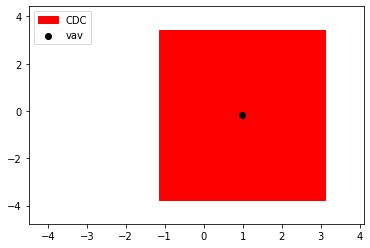

In [87]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Create figure and axes
fig, ax = plt.subplots()
janus_env = Janus()
# print(janus_env.vav_df)
# print(janus_env.ti)
# print(janus_env.ts)

inf_x = janus_env.ti.iloc[0][0]
sup_x = janus_env.ts.iloc[0][0]
inf_y = janus_env.ti.iloc[0][1]
sup_y = janus_env.ts.iloc[0][1]
inf_limx = min(inf_x, janus_env.y_df.min()[0])
sup_limx = max(sup_x, janus_env.y_df.max()[0])
inf_limy = min(inf_y, janus_env.y_df.min()[1])
sup_limy = max(sup_y, janus_env.y_df.max()[1])

# Create a Rectangle patch
rect = patches.Rectangle((inf_x, inf_y), (sup_x-inf_x), (sup_y-inf_y), linewidth=1, color='red', facecolor='none', label='CDC')
ax.add_patch(rect)

#create VAV point
plt.scatter(janus_env.vav_df.iloc[0].values[0], janus_env.vav_df.iloc[0].values[1], color='black', label='vav', zorder =2)

# Add the patch to the Axes
plt.xlim([inf_limx-1, sup_limx+1])
plt.ylim([inf_limy-1, sup_limy+1])
plt.legend()
plt.show()


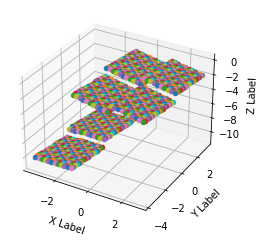

In [106]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].

X = np.arange(inf_limx, sup_limx, 0.2)
Y = np.arange(inf_limy, sup_limy, 0.2)
for x in X:
    for y in Y:
        z = janus_env.continuous_reward_clown_hat([x, y])
        ax.scatter(x, y, z)
    

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()